In [1]:
#IMPORTS

#File IO
import os
import glob

#Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn.functional as F
from torch.amp import GradScaler, autocast
from segmentation_models_pytorch import Unet

#Scikit learn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score

#Misc
from tqdm import tqdm


In [2]:
#HYPERPARMETERS

train_proportion = .8
val_proportion = .1

batch_size = 128
learning_rate = .00002
num_epochs = 100
loss_weights = (1.0, 1.0, 1.0, 1.0)

In [3]:
#LOAD DATASET

dataset = torch.load("dataset_scaled.pt", weights_only=False)

In [4]:
#CREATE DATALOADERS

train_size = int(train_proportion * len(dataset))
val_size = int(val_proportion * len(dataset))
test_size = len(dataset) - train_size - val_size

generator = torch.Generator().manual_seed(1)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
#CREATE MODEL

class MultiTaskV2(nn.Module):
    def __init__(self):
        super().__init__()

        self.cloud_mask_net = Unet(
            encoder_name='resnet34',
            in_channels=16,
            classes=1,
        )

        self.cloud_phase_net = Unet(
            encoder_name='resnet34',
            in_channels=17,
            classes=5,
        )
        self.cod_net = Unet(
            encoder_name='resnet34',
            in_channels=22,
            classes=1,
        )
        self.cps_net = Unet(
            encoder_name='resnet34',
            in_channels=22,
            classes=1,
        )

    def forward(self, x):
        cloud_mask_pred = self.cloud_mask_net(x)  # [B,1,H,W]
        x1 = torch.cat([x, cloud_mask_pred], dim=1)  # [B,17,H,W]
        cloud_phase_pred = self.cloud_phase_net(x1)  # [B,5,H,W]
        x2 = torch.cat([x1, cloud_phase_pred], dim=1)
        
        cod_pred = self.cod_net(x2)                # [B,1,H,W]
        cps_pred = self.cps_net(x2)                # [B,1,H,W]

        return cloud_mask_pred, cloud_phase_pred, cod_pred, cps_pred



In [6]:
#FINAL SETUP

dev_str = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(dev_str)
model = MultiTaskV2().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
scaler = GradScaler(device = device)

def unpack_labels(labels):
    return (
        labels[:, 0:1, :, :],             # cloud_mask → [B, H, W]
        labels[:, 1, :, :].long(),        # cloud_phase → [B, H, W]
        labels[:, 2:3, :, :],             # cod → [B, 1, H, W]
        labels[:, 3:4, :, :]              # cps → [B, 1, H, W]
    )


train_mask_losses, train_phase_losses, train_cod_losses, train_cps_losses, train_all_losses = [], [], [], [], []
val_mask_losses, val_phase_losses, val_cod_losses, val_cps_losses, val_all_losses = [], [], [], [], []

train_mask_acc, train_phase_acc, train_cod_r2, train_cps_r2 = [], [], [], []
val_mask_acc, val_phase_acc, val_cod_r2, val_cps_r2 = [], [], [], []

In [7]:
#TRAIN and EVALUATE FUNCTIONS

def train(model, train_loader, loss_weights=(1,1,1,1)):
    model.train()

    total_instances = 0 # Count number of instances in the epoch
    total_loss = total_loss_mask = total_loss_phase = total_loss_cod = total_loss_cps = 0 # Total loss and sublosses
    mask_correct = phase_correct = 0 # Number of correct guesses for cloud_mask and cloud_phase
    cod_preds, cod_labels = [], [] # Cod labels and predictions for calculating r2 
    cps_preds, cps_labels = [], [] # Cps labels and predictions for calculating r2

    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        cloud_mask_target, cloud_phase_target, cod_target, cps_target = unpack_labels(labels) # Get individual targets

        optimizer.zero_grad()
        B, _, H, W = labels.shape
        total_instances += (B * H * W) # Count instances in batch
        
        with autocast(device_type=dev_str):
            preds = model(inputs) # Model predictions

            # Loss in batch
            loss_mask = nn.BCEWithLogitsLoss()(preds[0], cloud_mask_target)
            loss_phase = nn.CrossEntropyLoss()(preds[1], cloud_phase_target)
            loss_cod = nn.MSELoss()(preds[2], cod_target)
            loss_cps = nn.MSELoss()(preds[3], cps_target)
            total_batch_loss = (
                loss_weights[0] * loss_mask +
                loss_weights[1] * loss_phase +
                loss_weights[2] * loss_cod +
                loss_weights[3] * loss_cps
            )

        # Get correct guesses for mask and phase
        mask_preds = (torch.sigmoid(preds[0]) > 0.5).long()
        mask_correct += (mask_preds == cloud_mask_target).sum().item()
        phase_preds = torch.argmax(preds[1], dim=1)
        phase_correct += (phase_preds == cloud_phase_target).sum().item()

        # Get predicted and actual cod and cps
        cod_preds.append(preds[2].cpu().detach().numpy())
        cod_labels.append(cod_target.cpu().numpy())
        cps_preds.append(preds[3].cpu().detach().numpy())
        cps_labels.append(cps_target.cpu().numpy())
            

        # Update model
        scaler.scale(total_batch_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Loss in epoch
        total_loss += total_batch_loss.item()
        total_loss_mask += loss_mask.item()
        total_loss_phase += loss_phase.item()
        total_loss_cod += loss_cod.item()
        total_loss_cps += loss_cps.item()

    # ------------------------------------ BATCH LOOP END -------------------------------------------------------------

    #Accuracy for mask and phase
    mask_accuracy = mask_correct/total_instances
    phase_accuracy = phase_correct/total_instances

    #Cod R2
    cod_preds = np.concatenate(cod_preds).ravel()
    cod_labels = np.concatenate(cod_labels).ravel()
    cod_r2 = r2_score(cod_labels, cod_preds)

    #Cps R2
    cps_preds = np.concatenate(cps_preds).ravel()
    cps_labels = np.concatenate(cps_labels).ravel()
    cps_r2 = r2_score(cps_labels, cps_preds)

    return {
        'loss_total': total_loss / len(train_loader),
        'loss_mask': total_loss_mask / len(train_loader),
        'loss_phase': total_loss_phase / len(train_loader),
        'loss_cod': total_loss_cod / len(train_loader),
        'loss_cps': total_loss_cps / len(train_loader),
        'acc_mask': mask_accuracy,
        'acc_phase': phase_accuracy,
        'r2_cod': cod_r2,
        'r2_cps': cps_r2
    }



def eval(model, val_loader, loss_weights=(1,1,1,1)):
    model.eval()

    total_instances = 0 # Count number of instances in the epoch
    total_loss = total_loss_mask = total_loss_phase = total_loss_cod = total_loss_cps = 0 # Total loss and sublosses
    mask_correct = phase_correct = 0 # Number of correct guesses for cloud_mask and cloud_phase
    cod_preds, cod_labels = [], [] # Cod labels and predictions for calculating r2 
    cps_preds, cps_labels = [], [] # Cps labels and predictions for calculating r2

    for inputs, labels in (val_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        cloud_mask_target, cloud_phase_target, cod_target, cps_target = unpack_labels(labels) # Get individual targets

        B, _, H, W = labels.shape
        total_instances += (B * H * W) # Count instances in batch
        
        
        with torch.no_grad(), autocast(device_type=dev_str):
            preds = model(inputs) # Model predictions

            # Loss in batch
            loss_mask = nn.BCEWithLogitsLoss()(preds[0], cloud_mask_target)
            loss_phase = nn.CrossEntropyLoss()(preds[1], cloud_phase_target)
            loss_cod = nn.MSELoss()(preds[2], cod_target)
            loss_cps = nn.MSELoss()(preds[3], cps_target)
            total_batch_loss = (
                loss_weights[0] * loss_mask +
                loss_weights[1] * loss_phase +
                loss_weights[2] * loss_cod +
                loss_weights[3] * loss_cps
            )

        # Get correct guesses for mask and phase
        mask_preds = (torch.sigmoid(preds[0]) > 0.5).long()
        mask_correct += (mask_preds == cloud_mask_target).sum().item()
        phase_preds = torch.argmax(preds[1], dim=1)
        phase_correct += (phase_preds == cloud_phase_target).sum().item()

        # Get predicted and actual cod and cps
        cod_preds.append(preds[2].cpu().detach().numpy())
        cod_labels.append(cod_target.cpu().numpy())
        cps_preds.append(preds[3].cpu().detach().numpy())
        cps_labels.append(cps_target.cpu().numpy())
            
        # Loss in epoch
        total_loss += total_batch_loss.item()
        total_loss_mask += loss_mask.item()
        total_loss_phase += loss_phase.item()
        total_loss_cod += loss_cod.item()
        total_loss_cps += loss_cps.item()

    # ------------------------------------ BATCH LOOP END -------------------------------------------------------------

    #Accuracy for mask and phase
    mask_accuracy = mask_correct/total_instances
    phase_accuracy = phase_correct/total_instances

    #Cod R2
    cod_preds = np.concatenate(cod_preds).ravel()
    cod_labels = np.concatenate(cod_labels).ravel()
    cod_r2 = r2_score(cod_labels, cod_preds)

    #Cps R2
    cps_preds = np.concatenate(cps_preds).ravel()
    cps_labels = np.concatenate(cps_labels).ravel()
    cps_r2 = r2_score(cps_labels, cps_preds)

    return {
        'loss_total': total_loss / len(val_loader),
        'loss_mask': total_loss_mask / len(val_loader),
        'loss_phase': total_loss_phase / len(val_loader),
        'loss_cod': total_loss_cod / len(val_loader),
        'loss_cps': total_loss_cps / len(val_loader),
        'acc_mask': mask_accuracy,
        'acc_phase': phase_accuracy,
        'r2_cod': cod_r2,
        'r2_cps': cps_r2
    }

In [8]:
#TRAIN MODEL

for e in range(1, num_epochs+1):
    train_results = train(model, train_loader, loss_weights = loss_weights)
    val_results = eval(model, val_loader, loss_weights = loss_weights)
    
    train_mask_losses.append(train_results['loss_mask'])
    train_phase_losses.append(train_results['loss_phase'])
    train_cod_losses.append(train_results['loss_cod'])
    train_cps_losses.append(train_results['loss_cps'])
    train_all_losses.append(train_results['loss_total'])

    train_mask_acc.append(train_results['acc_mask'])
    train_phase_acc.append(train_results['acc_phase'])
    train_cod_r2.append(train_results['r2_cod'])
    train_cps_r2.append(train_results['r2_cps'])

    val_mask_losses.append(val_results['loss_mask'])
    val_phase_losses.append(val_results['loss_phase'])
    val_cod_losses.append(val_results['loss_cod'])
    val_cps_losses.append(val_results['loss_cps'])
    val_all_losses.append(val_results['loss_total'])

    val_mask_acc.append(val_results['acc_mask'])
    val_phase_acc.append(val_results['acc_phase'])
    val_cod_r2.append(val_results['r2_cod'])
    val_cps_r2.append(val_results['r2_cps'])

    print(f"Epoch: {e} | Train Loss: {train_results['loss_total']:.4f} | Val Loss: {val_results['loss_total']:.4f} | Val Mask: {val_results['acc_mask']:.4f} | Val Phase: {val_results['acc_phase']:.4f} | Val Cod: {val_results['r2_cod']:.4f} | Val Cps: {val_results['r2_cps']:.4f}")


100%|██████████| 94/94 [00:27<00:00,  3.41it/s]


Epoch: 1 | Train Loss: 12.7917 | Val Loss: 13.1768 | Val Mask: 0.6918 | Val Phase: 0.2894 | Val Cod: -1.4002 | Val Cps: -2.5763


100%|██████████| 94/94 [00:25<00:00,  3.69it/s]


Epoch: 2 | Train Loss: 9.4477 | Val Loss: 8.2490 | Val Mask: 0.6918 | Val Phase: 0.3187 | Val Cod: -0.0968 | Val Cps: -1.0753


100%|██████████| 94/94 [00:25<00:00,  3.72it/s]


Epoch: 3 | Train Loss: 7.8648 | Val Loss: 7.2947 | Val Mask: 0.6954 | Val Phase: 0.3507 | Val Cod: 0.0832 | Val Cps: -0.7808


100%|██████████| 94/94 [00:25<00:00,  3.70it/s]


Epoch: 4 | Train Loss: 6.9828 | Val Loss: 6.8135 | Val Mask: 0.6965 | Val Phase: 0.3892 | Val Cod: 0.0655 | Val Cps: -0.5870


100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Epoch: 5 | Train Loss: 6.4100 | Val Loss: 6.3462 | Val Mask: 0.6950 | Val Phase: 0.4170 | Val Cod: 0.2809 | Val Cps: -0.5072


100%|██████████| 94/94 [00:25<00:00,  3.63it/s]


Epoch: 6 | Train Loss: 5.9266 | Val Loss: 5.7469 | Val Mask: 0.7008 | Val Phase: 0.4514 | Val Cod: 0.2486 | Val Cps: -0.2541


100%|██████████| 94/94 [00:25<00:00,  3.72it/s]


Epoch: 7 | Train Loss: 5.5528 | Val Loss: 5.3524 | Val Mask: 0.6990 | Val Phase: 0.4784 | Val Cod: 0.3269 | Val Cps: -0.1360


100%|██████████| 94/94 [00:25<00:00,  3.75it/s]


Epoch: 8 | Train Loss: 5.2282 | Val Loss: 4.7673 | Val Mask: 0.6967 | Val Phase: 0.4959 | Val Cod: 0.3634 | Val Cps: 0.0866


100%|██████████| 94/94 [00:24<00:00,  3.77it/s]


Epoch: 9 | Train Loss: 4.9379 | Val Loss: 5.0084 | Val Mask: 0.7012 | Val Phase: 0.5149 | Val Cod: 0.4756 | Val Cps: -0.0830


100%|██████████| 94/94 [00:24<00:00,  3.77it/s]


Epoch: 10 | Train Loss: 4.6883 | Val Loss: 5.3013 | Val Mask: 0.6973 | Val Phase: 0.5319 | Val Cod: 0.4528 | Val Cps: -0.2147


100%|██████████| 94/94 [00:24<00:00,  3.89it/s]


Epoch: 11 | Train Loss: 4.4747 | Val Loss: 4.3424 | Val Mask: 0.6998 | Val Phase: 0.5443 | Val Cod: 0.4292 | Val Cps: 0.2051


100%|██████████| 94/94 [00:25<00:00,  3.72it/s]


Epoch: 12 | Train Loss: 4.2774 | Val Loss: 4.4555 | Val Mask: 0.7030 | Val Phase: 0.5568 | Val Cod: 0.5078 | Val Cps: 0.1049


100%|██████████| 94/94 [00:24<00:00,  3.91it/s]


Epoch: 13 | Train Loss: 4.1174 | Val Loss: 4.3424 | Val Mask: 0.7028 | Val Phase: 0.5689 | Val Cod: 0.5105 | Val Cps: 0.1414


100%|██████████| 94/94 [00:24<00:00,  3.91it/s]


Epoch: 14 | Train Loss: 3.9619 | Val Loss: 3.9416 | Val Mask: 0.7030 | Val Phase: 0.5752 | Val Cod: 0.5243 | Val Cps: 0.3011


100%|██████████| 94/94 [00:24<00:00,  3.79it/s]


Epoch: 15 | Train Loss: 3.8362 | Val Loss: 3.7400 | Val Mask: 0.7058 | Val Phase: 0.5803 | Val Cod: 0.5348 | Val Cps: 0.3780


100%|██████████| 94/94 [00:24<00:00,  3.79it/s]


Epoch: 16 | Train Loss: 3.6916 | Val Loss: 3.9623 | Val Mask: 0.7078 | Val Phase: 0.5869 | Val Cod: 0.5190 | Val Cps: 0.2780


100%|██████████| 94/94 [00:24<00:00,  3.79it/s]


Epoch: 17 | Train Loss: 3.5805 | Val Loss: 3.5812 | Val Mask: 0.7103 | Val Phase: 0.5929 | Val Cod: 0.5348 | Val Cps: 0.4257


100%|██████████| 94/94 [00:24<00:00,  3.82it/s]


Epoch: 18 | Train Loss: 3.4812 | Val Loss: 3.3941 | Val Mask: 0.7113 | Val Phase: 0.5966 | Val Cod: 0.5688 | Val Cps: 0.4859


100%|██████████| 94/94 [00:25<00:00,  3.72it/s]


Epoch: 19 | Train Loss: 3.3808 | Val Loss: 3.3824 | Val Mask: 0.7127 | Val Phase: 0.6002 | Val Cod: 0.5712 | Val Cps: 0.4776


100%|██████████| 94/94 [00:24<00:00,  3.80it/s]


Epoch: 20 | Train Loss: 3.2996 | Val Loss: 3.5896 | Val Mask: 0.7136 | Val Phase: 0.6019 | Val Cod: 0.5826 | Val Cps: 0.3751


100%|██████████| 94/94 [00:25<00:00,  3.74it/s]


Epoch: 21 | Train Loss: 3.2251 | Val Loss: 3.3502 | Val Mask: 0.7149 | Val Phase: 0.6035 | Val Cod: 0.5932 | Val Cps: 0.4672


100%|██████████| 94/94 [00:25<00:00,  3.75it/s]


Epoch: 22 | Train Loss: 3.1573 | Val Loss: 3.2246 | Val Mask: 0.7159 | Val Phase: 0.6067 | Val Cod: 0.6074 | Val Cps: 0.5083


100%|██████████| 94/94 [00:25<00:00,  3.73it/s]


Epoch: 23 | Train Loss: 3.0934 | Val Loss: 3.1080 | Val Mask: 0.7185 | Val Phase: 0.6094 | Val Cod: 0.6119 | Val Cps: 0.5490


100%|██████████| 94/94 [00:25<00:00,  3.74it/s]


Epoch: 24 | Train Loss: 3.0450 | Val Loss: 3.0840 | Val Mask: 0.7200 | Val Phase: 0.6122 | Val Cod: 0.6051 | Val Cps: 0.5549


100%|██████████| 94/94 [00:25<00:00,  3.70it/s]


Epoch: 25 | Train Loss: 2.9881 | Val Loss: 3.0625 | Val Mask: 0.7222 | Val Phase: 0.6186 | Val Cod: 0.6045 | Val Cps: 0.5585


100%|██████████| 94/94 [00:24<00:00,  3.78it/s]


Epoch: 26 | Train Loss: 2.9459 | Val Loss: 2.9994 | Val Mask: 0.7229 | Val Phase: 0.6269 | Val Cod: 0.6190 | Val Cps: 0.5731


100%|██████████| 94/94 [00:24<00:00,  3.89it/s]


Epoch: 27 | Train Loss: 2.8991 | Val Loss: 3.1348 | Val Mask: 0.7244 | Val Phase: 0.6321 | Val Cod: 0.6222 | Val Cps: 0.5065


100%|██████████| 94/94 [00:24<00:00,  3.80it/s]


Epoch: 28 | Train Loss: 2.8727 | Val Loss: 2.9842 | Val Mask: 0.7268 | Val Phase: 0.6369 | Val Cod: 0.6212 | Val Cps: 0.5657


100%|██████████| 94/94 [00:23<00:00,  3.93it/s]


Epoch: 29 | Train Loss: 2.8248 | Val Loss: 2.9164 | Val Mask: 0.7292 | Val Phase: 0.6407 | Val Cod: 0.6422 | Val Cps: 0.5792


100%|██████████| 94/94 [00:24<00:00,  3.82it/s]


Epoch: 30 | Train Loss: 2.8101 | Val Loss: 2.9021 | Val Mask: 0.7316 | Val Phase: 0.6454 | Val Cod: 0.6241 | Val Cps: 0.5894


100%|██████████| 94/94 [00:24<00:00,  3.81it/s]


Epoch: 31 | Train Loss: 2.7565 | Val Loss: 2.8871 | Val Mask: 0.7340 | Val Phase: 0.6483 | Val Cod: 0.6434 | Val Cps: 0.5791


100%|██████████| 94/94 [00:24<00:00,  3.80it/s]


Epoch: 32 | Train Loss: 2.7330 | Val Loss: 2.8829 | Val Mask: 0.7347 | Val Phase: 0.6509 | Val Cod: 0.6475 | Val Cps: 0.5761


100%|██████████| 94/94 [00:24<00:00,  3.79it/s]


Epoch: 33 | Train Loss: 2.6947 | Val Loss: 2.7961 | Val Mask: 0.7372 | Val Phase: 0.6551 | Val Cod: 0.6467 | Val Cps: 0.6068


100%|██████████| 94/94 [00:23<00:00,  3.93it/s]


Epoch: 34 | Train Loss: 2.6786 | Val Loss: 2.7651 | Val Mask: 0.7388 | Val Phase: 0.6578 | Val Cod: 0.6516 | Val Cps: 0.6121


100%|██████████| 94/94 [00:24<00:00,  3.77it/s]


Epoch: 35 | Train Loss: 2.6503 | Val Loss: 2.8479 | Val Mask: 0.7419 | Val Phase: 0.6590 | Val Cod: 0.6394 | Val Cps: 0.5774


100%|██████████| 94/94 [00:25<00:00,  3.75it/s]


Epoch: 36 | Train Loss: 2.6214 | Val Loss: 2.7297 | Val Mask: 0.7437 | Val Phase: 0.6615 | Val Cod: 0.6416 | Val Cps: 0.6235


100%|██████████| 94/94 [00:25<00:00,  3.74it/s]


Epoch: 37 | Train Loss: 2.5843 | Val Loss: 2.6784 | Val Mask: 0.7460 | Val Phase: 0.6678 | Val Cod: 0.6661 | Val Cps: 0.6267


100%|██████████| 94/94 [00:24<00:00,  3.77it/s]


Epoch: 38 | Train Loss: 2.5576 | Val Loss: 2.6677 | Val Mask: 0.7479 | Val Phase: 0.6704 | Val Cod: 0.6686 | Val Cps: 0.6212


100%|██████████| 94/94 [00:24<00:00,  3.76it/s]


Epoch: 39 | Train Loss: 2.5414 | Val Loss: 2.6476 | Val Mask: 0.7500 | Val Phase: 0.6782 | Val Cod: 0.6669 | Val Cps: 0.6256


100%|██████████| 94/94 [00:25<00:00,  3.74it/s]


Epoch: 40 | Train Loss: 2.5093 | Val Loss: 2.6385 | Val Mask: 0.7517 | Val Phase: 0.6776 | Val Cod: 0.6530 | Val Cps: 0.6365


100%|██████████| 94/94 [00:25<00:00,  3.75it/s]


Epoch: 41 | Train Loss: 2.4836 | Val Loss: 2.5793 | Val Mask: 0.7533 | Val Phase: 0.6913 | Val Cod: 0.6738 | Val Cps: 0.6425


100%|██████████| 94/94 [00:25<00:00,  3.70it/s]


Epoch: 42 | Train Loss: 2.4618 | Val Loss: 2.5751 | Val Mask: 0.7559 | Val Phase: 0.6961 | Val Cod: 0.6679 | Val Cps: 0.6392


100%|██████████| 94/94 [00:25<00:00,  3.72it/s]


Epoch: 43 | Train Loss: 2.4398 | Val Loss: 2.5405 | Val Mask: 0.7572 | Val Phase: 0.7037 | Val Cod: 0.6742 | Val Cps: 0.6461


100%|██████████| 94/94 [00:25<00:00,  3.68it/s]


Epoch: 44 | Train Loss: 2.4148 | Val Loss: 2.5248 | Val Mask: 0.7590 | Val Phase: 0.7072 | Val Cod: 0.6770 | Val Cps: 0.6464


100%|██████████| 94/94 [00:25<00:00,  3.72it/s]


Epoch: 45 | Train Loss: 2.3907 | Val Loss: 2.5109 | Val Mask: 0.7612 | Val Phase: 0.7162 | Val Cod: 0.6821 | Val Cps: 0.6460


100%|██████████| 94/94 [00:23<00:00,  3.93it/s]


Epoch: 46 | Train Loss: 2.3684 | Val Loss: 2.5122 | Val Mask: 0.7625 | Val Phase: 0.7215 | Val Cod: 0.6797 | Val Cps: 0.6426


100%|██████████| 94/94 [00:24<00:00,  3.77it/s]


Epoch: 47 | Train Loss: 2.3501 | Val Loss: 2.4588 | Val Mask: 0.7644 | Val Phase: 0.7209 | Val Cod: 0.6858 | Val Cps: 0.6555


100%|██████████| 94/94 [00:24<00:00,  3.88it/s]


Epoch: 48 | Train Loss: 2.3261 | Val Loss: 2.4742 | Val Mask: 0.7662 | Val Phase: 0.7295 | Val Cod: 0.6806 | Val Cps: 0.6463


100%|██████████| 94/94 [00:24<00:00,  3.79it/s]


Epoch: 49 | Train Loss: 2.3052 | Val Loss: 2.4443 | Val Mask: 0.7678 | Val Phase: 0.7278 | Val Cod: 0.6899 | Val Cps: 0.6505


100%|██████████| 94/94 [00:24<00:00,  3.87it/s]


Epoch: 50 | Train Loss: 2.2915 | Val Loss: 2.4679 | Val Mask: 0.7696 | Val Phase: 0.7294 | Val Cod: 0.6590 | Val Cps: 0.6506


100%|██████████| 94/94 [00:24<00:00,  3.78it/s]


Epoch: 51 | Train Loss: 2.2737 | Val Loss: 2.4781 | Val Mask: 0.7706 | Val Phase: 0.7336 | Val Cod: 0.6858 | Val Cps: 0.6370


100%|██████████| 94/94 [00:23<00:00,  3.94it/s]


Epoch: 52 | Train Loss: 2.2678 | Val Loss: 2.4219 | Val Mask: 0.7725 | Val Phase: 0.7403 | Val Cod: 0.6911 | Val Cps: 0.6493


100%|██████████| 94/94 [00:24<00:00,  3.77it/s]


Epoch: 53 | Train Loss: 2.2427 | Val Loss: 2.4064 | Val Mask: 0.7740 | Val Phase: 0.7413 | Val Cod: 0.6725 | Val Cps: 0.6629


100%|██████████| 94/94 [00:25<00:00,  3.73it/s]


Epoch: 54 | Train Loss: 2.2183 | Val Loss: 2.3747 | Val Mask: 0.7756 | Val Phase: 0.7294 | Val Cod: 0.7002 | Val Cps: 0.6575


100%|██████████| 94/94 [00:25<00:00,  3.75it/s]


Epoch: 55 | Train Loss: 2.2085 | Val Loss: 2.3888 | Val Mask: 0.7769 | Val Phase: 0.7414 | Val Cod: 0.6878 | Val Cps: 0.6566


100%|██████████| 94/94 [00:24<00:00,  3.76it/s]


Epoch: 56 | Train Loss: 2.1797 | Val Loss: 2.4460 | Val Mask: 0.7781 | Val Phase: 0.7095 | Val Cod: 0.6966 | Val Cps: 0.6345


100%|██████████| 94/94 [00:25<00:00,  3.75it/s]


Epoch: 57 | Train Loss: 2.1616 | Val Loss: 2.3937 | Val Mask: 0.7791 | Val Phase: 0.7240 | Val Cod: 0.6986 | Val Cps: 0.6448


100%|██████████| 94/94 [00:25<00:00,  3.76it/s]


Epoch: 58 | Train Loss: 2.1346 | Val Loss: 2.3113 | Val Mask: 0.7807 | Val Phase: 0.7423 | Val Cod: 0.6996 | Val Cps: 0.6754


100%|██████████| 94/94 [00:24<00:00,  3.79it/s]


Epoch: 59 | Train Loss: 2.1256 | Val Loss: 2.2876 | Val Mask: 0.7818 | Val Phase: 0.7549 | Val Cod: 0.7052 | Val Cps: 0.6702


100%|██████████| 94/94 [00:25<00:00,  3.75it/s]


Epoch: 60 | Train Loss: 2.1075 | Val Loss: 2.2933 | Val Mask: 0.7832 | Val Phase: 0.7523 | Val Cod: 0.6872 | Val Cps: 0.6745


100%|██████████| 94/94 [00:25<00:00,  3.74it/s]


Epoch: 61 | Train Loss: 2.0995 | Val Loss: 2.3054 | Val Mask: 0.7841 | Val Phase: 0.7622 | Val Cod: 0.6763 | Val Cps: 0.6593


100%|██████████| 94/94 [00:25<00:00,  3.75it/s]


Epoch: 62 | Train Loss: 2.0733 | Val Loss: 2.2172 | Val Mask: 0.7853 | Val Phase: 0.7624 | Val Cod: 0.7066 | Val Cps: 0.6798


100%|██████████| 94/94 [00:25<00:00,  3.64it/s]


Epoch: 63 | Train Loss: 2.0655 | Val Loss: 2.3215 | Val Mask: 0.7867 | Val Phase: 0.7442 | Val Cod: 0.6947 | Val Cps: 0.6484


100%|██████████| 94/94 [00:26<00:00,  3.59it/s]


Epoch: 64 | Train Loss: 2.0448 | Val Loss: 2.2159 | Val Mask: 0.7878 | Val Phase: 0.7708 | Val Cod: 0.7024 | Val Cps: 0.6719


100%|██████████| 94/94 [00:24<00:00,  3.80it/s]


Epoch: 65 | Train Loss: 2.0337 | Val Loss: 2.1846 | Val Mask: 0.7887 | Val Phase: 0.7586 | Val Cod: 0.7092 | Val Cps: 0.6825


100%|██████████| 94/94 [00:25<00:00,  3.71it/s]


Epoch: 66 | Train Loss: 2.0213 | Val Loss: 2.1722 | Val Mask: 0.7901 | Val Phase: 0.7736 | Val Cod: 0.7078 | Val Cps: 0.6779


100%|██████████| 94/94 [00:25<00:00,  3.74it/s]


Epoch: 67 | Train Loss: 2.0290 | Val Loss: 2.2287 | Val Mask: 0.7899 | Val Phase: 0.7487 | Val Cod: 0.6885 | Val Cps: 0.6795


100%|██████████| 94/94 [00:25<00:00,  3.67it/s]


Epoch: 68 | Train Loss: 2.0057 | Val Loss: 2.3959 | Val Mask: 0.7912 | Val Phase: 0.7156 | Val Cod: 0.7078 | Val Cps: 0.6258


100%|██████████| 94/94 [00:25<00:00,  3.70it/s]


Epoch: 69 | Train Loss: 2.0115 | Val Loss: 2.1064 | Val Mask: 0.7925 | Val Phase: 0.7753 | Val Cod: 0.7144 | Val Cps: 0.6931


100%|██████████| 94/94 [00:25<00:00,  3.75it/s]


Epoch: 70 | Train Loss: 1.9576 | Val Loss: 2.1919 | Val Mask: 0.7941 | Val Phase: 0.7688 | Val Cod: 0.7143 | Val Cps: 0.6612


100%|██████████| 94/94 [00:24<00:00,  3.88it/s]


Epoch: 71 | Train Loss: 1.9327 | Val Loss: 2.0661 | Val Mask: 0.7957 | Val Phase: 0.7863 | Val Cod: 0.7117 | Val Cps: 0.6984


100%|██████████| 94/94 [00:24<00:00,  3.76it/s]


Epoch: 72 | Train Loss: 1.9117 | Val Loss: 2.0656 | Val Mask: 0.7974 | Val Phase: 0.7857 | Val Cod: 0.7149 | Val Cps: 0.6924


100%|██████████| 94/94 [00:24<00:00,  3.76it/s]


Epoch: 73 | Train Loss: 1.9039 | Val Loss: 2.1618 | Val Mask: 0.7994 | Val Phase: 0.7508 | Val Cod: 0.7119 | Val Cps: 0.6870


100%|██████████| 94/94 [00:24<00:00,  3.91it/s]


Epoch: 74 | Train Loss: 1.8901 | Val Loss: 2.0282 | Val Mask: 0.8016 | Val Phase: 0.7832 | Val Cod: 0.7168 | Val Cps: 0.7025


100%|██████████| 94/94 [00:25<00:00,  3.72it/s]


Epoch: 75 | Train Loss: 1.8605 | Val Loss: 2.0352 | Val Mask: 0.8041 | Val Phase: 0.7768 | Val Cod: 0.7171 | Val Cps: 0.7002


100%|██████████| 94/94 [00:24<00:00,  3.83it/s]


Epoch: 76 | Train Loss: 1.8458 | Val Loss: 2.0135 | Val Mask: 0.8073 | Val Phase: 0.7838 | Val Cod: 0.7184 | Val Cps: 0.7010


100%|██████████| 94/94 [00:25<00:00,  3.71it/s]


Epoch: 77 | Train Loss: 1.8302 | Val Loss: 2.0605 | Val Mask: 0.8107 | Val Phase: 0.7868 | Val Cod: 0.7068 | Val Cps: 0.6805


100%|██████████| 94/94 [00:25<00:00,  3.74it/s]


Epoch: 78 | Train Loss: 1.8175 | Val Loss: 2.0509 | Val Mask: 0.8146 | Val Phase: 0.7497 | Val Cod: 0.7255 | Val Cps: 0.7033


100%|██████████| 94/94 [00:24<00:00,  3.77it/s]


Epoch: 79 | Train Loss: 1.7985 | Val Loss: 1.9518 | Val Mask: 0.8179 | Val Phase: 0.7983 | Val Cod: 0.7203 | Val Cps: 0.7065


100%|██████████| 94/94 [00:25<00:00,  3.76it/s]


Epoch: 80 | Train Loss: 1.7810 | Val Loss: 2.0477 | Val Mask: 0.8232 | Val Phase: 0.7635 | Val Cod: 0.7179 | Val Cps: 0.6941


100%|██████████| 94/94 [00:24<00:00,  3.77it/s]


Epoch: 81 | Train Loss: 1.7647 | Val Loss: 1.9578 | Val Mask: 0.8278 | Val Phase: 0.7925 | Val Cod: 0.7172 | Val Cps: 0.7024


100%|██████████| 94/94 [00:24<00:00,  3.77it/s]


Epoch: 82 | Train Loss: 1.7526 | Val Loss: 1.9009 | Val Mask: 0.8306 | Val Phase: 0.8089 | Val Cod: 0.7218 | Val Cps: 0.7099


100%|██████████| 94/94 [00:24<00:00,  3.79it/s]


Epoch: 83 | Train Loss: 1.7266 | Val Loss: 2.0488 | Val Mask: 0.8357 | Val Phase: 0.7864 | Val Cod: 0.6597 | Val Cps: 0.6951


100%|██████████| 94/94 [00:24<00:00,  3.78it/s]


Epoch: 84 | Train Loss: 1.7249 | Val Loss: 1.9527 | Val Mask: 0.8404 | Val Phase: 0.8042 | Val Cod: 0.6861 | Val Cps: 0.7043


100%|██████████| 94/94 [00:23<00:00,  3.92it/s]


Epoch: 85 | Train Loss: 1.7131 | Val Loss: 1.9620 | Val Mask: 0.8448 | Val Phase: 0.7803 | Val Cod: 0.7129 | Val Cps: 0.7063


100%|██████████| 94/94 [00:25<00:00,  3.75it/s]


Epoch: 86 | Train Loss: 1.6902 | Val Loss: 2.0092 | Val Mask: 0.8480 | Val Phase: 0.7655 | Val Cod: 0.7187 | Val Cps: 0.6934


100%|██████████| 94/94 [00:24<00:00,  3.77it/s]


Epoch: 87 | Train Loss: 1.6792 | Val Loss: 1.8833 | Val Mask: 0.8510 | Val Phase: 0.8102 | Val Cod: 0.7161 | Val Cps: 0.7069


100%|██████████| 94/94 [00:25<00:00,  3.72it/s]


Epoch: 88 | Train Loss: 1.6586 | Val Loss: 1.8711 | Val Mask: 0.8533 | Val Phase: 0.8017 | Val Cod: 0.7233 | Val Cps: 0.7120


100%|██████████| 94/94 [00:24<00:00,  3.84it/s]


Epoch: 89 | Train Loss: 1.6478 | Val Loss: 1.8801 | Val Mask: 0.8563 | Val Phase: 0.8103 | Val Cod: 0.7264 | Val Cps: 0.6981


100%|██████████| 94/94 [00:26<00:00,  3.58it/s]


Epoch: 90 | Train Loss: 1.6551 | Val Loss: 1.8238 | Val Mask: 0.8590 | Val Phase: 0.8233 | Val Cod: 0.7132 | Val Cps: 0.7139


100%|██████████| 94/94 [00:24<00:00,  3.78it/s]


Epoch: 91 | Train Loss: 1.6182 | Val Loss: 1.8341 | Val Mask: 0.8619 | Val Phase: 0.8126 | Val Cod: 0.7120 | Val Cps: 0.7155


100%|██████████| 94/94 [00:25<00:00,  3.76it/s]


Epoch: 92 | Train Loss: 1.5961 | Val Loss: 1.8636 | Val Mask: 0.8643 | Val Phase: 0.8024 | Val Cod: 0.7164 | Val Cps: 0.7098


100%|██████████| 94/94 [00:24<00:00,  3.81it/s]


Epoch: 93 | Train Loss: 1.5908 | Val Loss: 1.8585 | Val Mask: 0.8672 | Val Phase: 0.8110 | Val Cod: 0.7238 | Val Cps: 0.6939


100%|██████████| 94/94 [00:25<00:00,  3.71it/s]


Epoch: 94 | Train Loss: 1.5698 | Val Loss: 1.7900 | Val Mask: 0.8700 | Val Phase: 0.8164 | Val Cod: 0.7257 | Val Cps: 0.7197


100%|██████████| 94/94 [00:25<00:00,  3.74it/s]


Epoch: 95 | Train Loss: 1.5617 | Val Loss: 1.7765 | Val Mask: 0.8726 | Val Phase: 0.8207 | Val Cod: 0.7244 | Val Cps: 0.7147


100%|██████████| 94/94 [00:24<00:00,  3.76it/s]


Epoch: 96 | Train Loss: 1.5449 | Val Loss: 1.7720 | Val Mask: 0.8750 | Val Phase: 0.8271 | Val Cod: 0.7274 | Val Cps: 0.7073


100%|██████████| 94/94 [00:25<00:00,  3.75it/s]


Epoch: 97 | Train Loss: 1.5351 | Val Loss: 1.7521 | Val Mask: 0.8778 | Val Phase: 0.8307 | Val Cod: 0.7316 | Val Cps: 0.7076


100%|██████████| 94/94 [00:25<00:00,  3.76it/s]


Epoch: 98 | Train Loss: 1.5081 | Val Loss: 1.8297 | Val Mask: 0.8809 | Val Phase: 0.7927 | Val Cod: 0.7218 | Val Cps: 0.7143


100%|██████████| 94/94 [00:24<00:00,  3.91it/s]


Epoch: 99 | Train Loss: 1.4968 | Val Loss: 1.7640 | Val Mask: 0.8825 | Val Phase: 0.8077 | Val Cod: 0.7340 | Val Cps: 0.7180


100%|██████████| 94/94 [00:25<00:00,  3.73it/s]


Epoch: 100 | Train Loss: 1.4882 | Val Loss: 1.8944 | Val Mask: 0.8853 | Val Phase: 0.7744 | Val Cod: 0.7197 | Val Cps: 0.6925


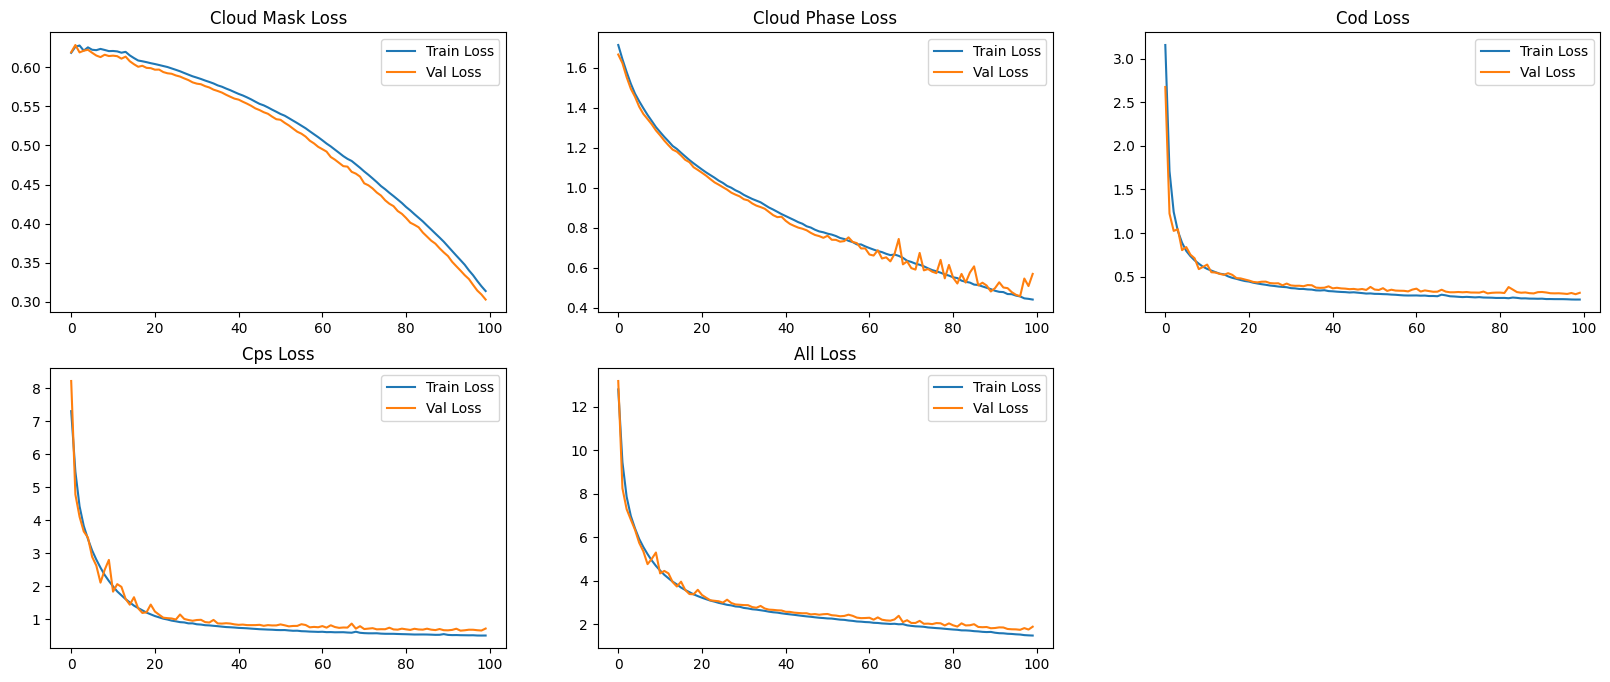

In [9]:
#PLOT LOSS

plt.figure(figsize=(20,8))

plt.subplot(2, 3, 1)
plt.plot(train_mask_losses, label='Train Loss')
plt.plot(val_mask_losses, label='Val Loss')
plt.title('Cloud Mask Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(train_phase_losses, label='Train Loss')
plt.plot(val_phase_losses, label='Val Loss')
plt.title('Cloud Phase Loss')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(train_cod_losses, label='Train Loss')
plt.plot(val_cod_losses, label='Val Loss')
plt.title('Cod Loss')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(train_cps_losses, label='Train Loss')
plt.plot(val_cps_losses, label='Val Loss')
plt.title('Cps Loss')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(train_all_losses, label='Train Loss')
plt.plot(val_all_losses, label='Val Loss')
plt.title('All Loss')
plt.legend()

plt.savefig("./graphs/MultiTaskV2_loss.png")  

plt.show()

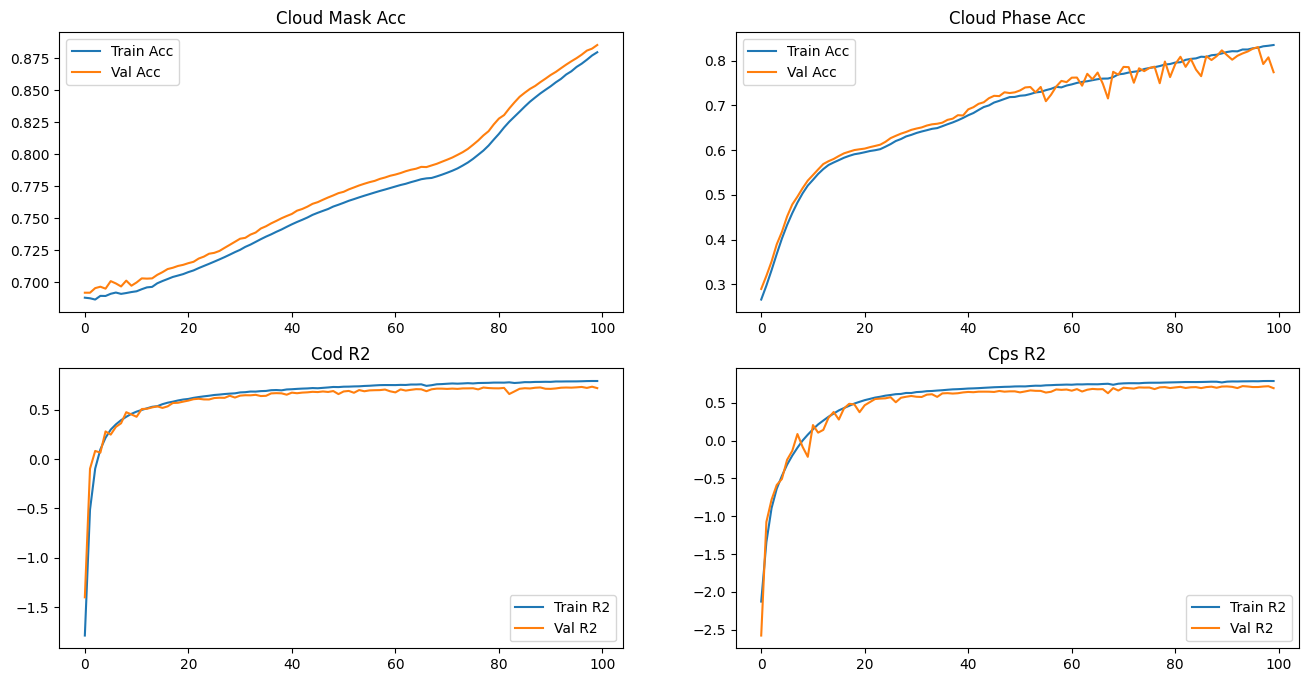

In [10]:
#PLOT ACCURACY

plt.figure(figsize=(16,8))

plt.subplot(2, 2, 1)
plt.plot(train_mask_acc, label='Train Acc')
plt.plot(val_mask_acc, label='Val Acc')
plt.title('Cloud Mask Acc')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_phase_acc, label='Train Acc')
plt.plot(val_phase_acc, label='Val Acc')
plt.title('Cloud Phase Acc')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(train_cod_r2, label='Train R2')
plt.plot(val_cod_r2, label='Val R2')
plt.title('Cod R2')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(train_cps_r2, label='Train R2')
plt.plot(val_cps_r2, label='Val R2')
plt.title('Cps R2')
plt.legend()

plt.savefig("./graphs/MultiTaskV2_acc.png")  

plt.show()


In [11]:
# MODEL EVALUATION — CLOUD MASK

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        cloud_mask_target, _, _, _ = unpack_labels(labels)
        cloud_mask_pred, _, _, _ = model(images)

        probs = torch.sigmoid(cloud_mask_pred)
        preds = (probs > 0.5).long()

        all_preds.append(preds.cpu().numpy())
        all_labels.append(cloud_mask_target.cpu().numpy())

# Flatten predictions and labels
all_preds = np.concatenate([p.flatten() for p in all_preds])
all_labels = np.concatenate([l.flatten() for l in all_labels])

# Classification report and IoU
report = classification_report(
    all_labels, all_preds,
    labels=[0, 1],
    digits=3,
    output_dict=True,
    zero_division=0
)
f1_scores = np.array([report[str(i)]['f1-score'] for i in range(2)])
supports = np.array([report[str(i)]['support'] for i in range(2)])
iou = f1_scores / (2 - f1_scores)

# Output
print("CLOUD MASK REPORT:\n", classification_report(all_labels, all_preds, labels=[0, 1], digits=3))
print("CONFUSION MATRIX:\n", confusion_matrix(all_labels, all_preds, labels=[0, 1]))
print("\nIOU:", iou)
print("Unweighted IoU:", np.mean(iou))
print("Weighted IoU:", np.average(iou, weights=supports))

100%|██████████| 12/12 [00:01<00:00,  8.24it/s]


CLOUD MASK REPORT:
               precision    recall  f1-score   support

           0      0.794     0.653     0.716   5803166
           1      0.898     0.947     0.922  18740066

    accuracy                          0.878  24543232
   macro avg      0.846     0.800     0.819  24543232
weighted avg      0.873     0.878     0.873  24543232

CONFUSION MATRIX:
 [[ 3787739  2015427]
 [  984976 17755090]]

IOU: [0.55799348 0.85544053]
Unweighted IoU: 0.7067170083011303
Weighted IoU: 0.7851101624726763


In [12]:
# MODEL EVALUATION — CLOUD PHASE

num_classes = 5

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        _, cloud_phase_target, _, _ = unpack_labels(labels)
        _, cloud_phase_pred, _, _ = model(images)
        preds = torch.argmax(cloud_phase_pred, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(cloud_phase_target.cpu().numpy())
        
# Flatten predictions and labels
all_preds = np.concatenate([p.flatten() for p in all_preds])
all_labels = np.concatenate([l.flatten() for l in all_labels])

# Classification report and IoU
report = classification_report(all_labels, all_preds, digits=3, output_dict=True)
f1_scores = np.array([report[str(i)]['f1-score'] for i in range(num_classes)])
supports = np.array([report[str(i)]['support'] for i in range(num_classes)])
iou = f1_scores / (2 - f1_scores)

# Output
print("CLOUD PHASE REPORT:\n", classification_report(all_labels, all_preds, digits=3))
print("CONFUSION MATRIX:\n", confusion_matrix(all_labels, all_preds))
print("\nIOU:", iou)
print("Unweighted IoU:", np.mean(iou))
print("Weighted IoU:", np.average(iou, weights=supports))


100%|██████████| 12/12 [00:01<00:00,  8.45it/s]


CLOUD PHASE REPORT:
               precision    recall  f1-score   support

           0      0.904     0.304     0.455   4373397
           1      0.732     0.924     0.817  10864796
           2      0.677     0.821     0.742   2400565
           3      0.457     0.064     0.112    890044
           4      0.820     0.860     0.839   6014430

    accuracy                          0.757  24543232
   macro avg      0.718     0.595     0.593  24543232
weighted avg      0.769     0.757     0.725  24543232

CONFUSION MATRIX:
 [[ 1328672  2828865    66790     1443   147627]
 [  122847 10043302   356890      176   341581]
 [    1257   180888  1971933    36474   210013]
 [     233    45859   348294    56553   439105]
 [   17075   630105   167879    28999  5170372]]

IOU: [0.29429196 0.69023697 0.59032522 0.05908565 0.72285033]
Unweighted IoU: 0.4713580254010461
Weighted IoU: 0.5950143415072384


In [13]:
# MODEL EVALUATION — CLOUD OPTICAL DISTANCE

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device).float()
        labels = labels.to(device)

        _, _, cod_target, _ = unpack_labels(labels)
        _, _, cod_pred, _ = model(images)
        
        all_preds.append(cod_pred.cpu().numpy().reshape(-1))
        all_labels.append(cod_target.cpu().numpy().reshape(-1))

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("r2:", r2_score(all_labels, all_preds))
print("MSE:", mean_squared_error(all_labels, all_preds))

100%|██████████| 12/12 [00:01<00:00,  8.22it/s]


r2: 0.7190561294555664
MSE: 0.3234347105026245


In [14]:
# MODEL EVALUATION — CLOUD PARTICLE SIZE

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device).float()
        labels = labels.to(device)

        _, _, _, cps_target = unpack_labels(labels)
        _, _, _, cps_pred = model(images)
        
        all_preds.append(cps_pred.cpu().numpy().reshape(-1))
        all_labels.append(cps_target.cpu().numpy().reshape(-1))

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("r2:", r2_score(all_labels, all_preds))
print("MSE:", mean_squared_error(all_labels, all_preds))

100%|██████████| 12/12 [00:01<00:00,  8.33it/s]


r2: 0.6870226263999939
MSE: 0.7518845200538635
